In [122]:
import sys, os, importlib
import rasterio
import reverse_geocode

import geopandas as gpd
import pandas as pd

# Import GOST libraries; sys.path.append will be unnecessary if libraries are already installed
sys.path.append("../../../../gostrocks/src")
sys.path.append("../../../../GOST_Urban")

import GOSTRocks.rasterMisc as rMisc
from GOSTRocks.misc import tPrint
import src.UrbanRaster as urban
%matplotlib inline  

In [49]:
# define and extract focal data
iso3 = "TUR"
nuts2_file = "/home/public/Data/COUNTRY/TUR/attributes/attributes.geojson"
inD = gpd.read_file(nuts2_file)
pop_file = "/home/public/Data/COUNTRY/TUR/Population/ppp_2020_1km_Aggregated.tif"

turkey_wsf = "/home/public/Data/GLOBAL/WSF/Turkey/Turkey_WSF_evolution.tif"
global_friction = "/home/public/Data/GLOBAL/INFRA/FRICTION_2020/2020_motorized_friction_surface.geotiff"
global_population = "/home/public/Data/GLOBAL/Population/WorldPop_PPP_2020/ppp_2020_1km_Aggregated.tif"
if not os.path.exists(pop_file):
    outFile = os.path.join("/home/wb411133/temp/TUR", os.path.basename(pop_file))
    rMisc.clipRaster(rasterio.open(global_population), inD, outFile)

urban_raster = "/home/public/Data/COUNTRY/TUR/URBAN_DATA/tur_urban.tif"
tt_folder = "/home/public/Data/COUNTRY/TUR/travel_time"
tt_airports = os.path.join(tt_folder, "least_cost_travel_time_airports.tif")
tt_hospitals = os.path.join(tt_folder, "least_cost_travel_time_hospitals.tif")

In [132]:
# Extract NUTS divisions
nuts_file = "/home/public/Data/GLOBAL/ADMIN/NUTS/NUTS_RG_01M_2021_4326.geojson"
inN = gpd.read_file(nuts_file)

inT1 = inN.loc[(inN['CNTR_CODE'] == "TR") & (inN['LEVL_CODE'] == 1)]
inT2 = inN.loc[(inN['CNTR_CODE'] == "TR") & (inN['LEVL_CODE'] == 2)]
inT3 = inN.loc[(inN['CNTR_CODE'] == "TR") & (inN['LEVL_CODE'] == 3)]


,id,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry
0,CZ,CZ,0,CZ,Česko,Česko,0.0,NaN,NaN,CZ,"POLYGON ((14.49122 51.04353, 14.49945 51.04610..."
1,DE,DE,0,DE,Deutschland,Deutschland,0.0,NaN,NaN,DE,"MULTIPOLYGON (((10.45444 47.55580, 10.43954 47..."
2,DK,DK,0,DK,Danmark,Danmark,0.0,NaN,NaN,DK,"MULTIPOLYGON (((10.19436 56.68466, 10.20395 56..."
3,AL,AL,0,AL,Shqipëria,Shqipëria,0.0,NaN,NaN,AL,"MULTIPOLYGON (((19.83100 42.46645, 19.83568 42..."
4,CY,CY,0,CY,Kýpros,Κύπρος,0.0,NaN,NaN,CY,"MULTIPOLYGON (((34.58451 35.69436, 34.57359 35..."


In [ ]:
# Standardize rasters to the population layer
popR = rasterio.open(pop_file)
for rFile in [urban_raster, tt_airports, tt_hospitals]:
    curR = rasterio.open(rFile)
    out_file = os.path.join("/home/wb411133/temp/TUR", os.path.basename(rFile))
    rMisc.standardizeInputRasters(rasterio.open(rFile), popR, out_file)


In [99]:
# Name urban extents
urban_extents = "/home/public/Data/COUNTRY/TUR/urbanization/tur_urban.shp"
in_ext = gpd.read_file(urban_extents)


TypeError: 'int' object is not iterable

In [110]:
centroids = [(x.centroid.y, x.centroid.x) for x in in_ext['geometry']]
res = reverse_geocode.search(centroids)

[{'country_code': 'TR', 'city': 'Sinop', 'country': 'Turkey'},
 {'country_code': 'TR', 'city': 'Sinop', 'country': 'Turkey'},
 {'country_code': 'TR', 'city': 'İnebolu', 'country': 'Turkey'},
 {'country_code': 'TR', 'city': 'Ayancık', 'country': 'Turkey'},
 {'country_code': 'TR', 'city': 'Gerze', 'country': 'Turkey'},
 {'country_code': 'TR', 'city': 'Kırklareli', 'country': 'Turkey'},
 {'country_code': 'TR', 'city': 'Edirne', 'country': 'Turkey'},
 {'country_code': 'TR', 'city': 'Pınarhisar', 'country': 'Turkey'},
 {'country_code': 'TR', 'city': 'Alaçam', 'country': 'Turkey'},
 {'country_code': 'TR', 'city': 'Bartın', 'country': 'Turkey'},
 {'country_code': 'TR', 'city': 'Vize', 'country': 'Turkey'},
 {'country_code': 'TR', 'city': 'Bafra', 'country': 'Turkey'},
 {'country_code': 'TR', 'city': 'Taşköprü', 'country': 'Turkey'},
 {'country_code': 'TR', 'city': 'Boyabat', 'country': 'Turkey'},
 {'country_code': 'TR', 'city': 'Babaeski', 'country': 'Turkey'},
 {'country_code': 'TR', 'city':

In [112]:
city_names = [x['city'] for x in res]
in_ext['CITY'] = city_names
in_ext.to_file("/home/wb411133/temp/tur_urban_named.shp")

# Summarize population in urban and travel times

In [9]:
# summarize urbanization
popR = rasterio.open(pop_file)
res = rMisc.zonalStats(inD, popR, minVal=0)
res = pd.DataFrame(res, columns=['SUM', 'MIN', 'MAX', 'MEAN'])
inD['wp_pop'] = res['SUM']

urbanR = rasterio.open(urban_raster)
urbanD = urbanR.read()
popD = popR.read()
urbanPop = urbanD * popD

with rMisc.create_rasterio_inmemory(popR.profile, urbanPop) as urbanPopR:
    res = rMisc.zonalStats(inD, urbanPopR, minVal=0)
    res = pd.DataFrame(res, columns=['SUM', 'MIN', 'MAX', 'MEAN'])
    inD['urban_pop'] = res['SUM']
    
inD['per_urban'] = inD['urban_pop'] / inD['wp_pop']

In [7]:
#Summarize travel time
thresh = 60
popD = popR.read()

for tt_file in [tt_airports, tt_hospitals]:
    field_name = "%s_%s" % (tt_file.split("_")[-1].replace(".tif", ""), thresh)
    ttR = rasterio.open(tt_file)
    ttD = ttR.read() < thresh
    ttPop = popD * ttD
    with rMisc.create_rasterio_inmemory(popR.profile, ttPop) as urbanPopR:
        res = rMisc.zonalStats(inD, urbanPopR, minVal=0)
        res = pd.DataFrame(res, columns=['SUM', 'MIN', 'MAX', 'MEAN'])
        inD[field_name] = res['SUM']

In [10]:
inD.head()

,id,GID_0,NAME_0,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,nuts2_regions,nuts1_regions,nuts1_labels,...,nuts2_development_level_2004,nuts2_development_level_2018,nuts1_growth_speed,nuts2_growth_speed,geometry,wp_pop,urban_pop,airports_60,hospitals_60,per_urban
0,1,TUR,Turkey,,Il,Province,,TR10,TR1,Istanbul Region,...,More developed,More developed,Average growth,Average growth,"MULTIPOLYGON (((28.18166 41.56406, 28.18987 41...",1.578518e+07,1.422525e+07,1.514880e+07,1.532639e+07,0.901178
1,2,TUR,Turkey,,Il,Province,,TR21,TR2,West Marmara Region,...,More developed,More developed,Low growth,Low growth,"POLYGON ((28.03551 41.98308, 28.02805 41.98082...",1.755714e+06,9.234421e+05,6.146452e+05,1.704351e+06,0.525964
2,3,TUR,Turkey,,Il,Province,,TR22,TR2,West Marmara Region,...,Transition,Transition,Low growth,Low growth,"MULTIPOLYGON (((28.16478 40.39561, 28.16460 40...",1.719822e+06,8.313265e+05,3.985374e+05,1.532288e+06,0.483379
3,4,TUR,Turkey,,Il,Province,,TR31,TR3,Aegean Region,...,More developed,More developed,Average growth,Low growth,"MULTIPOLYGON (((28.44261 38.10466, 28.41953 38...",4.169740e+06,3.330121e+06,3.542556e+06,3.940764e+06,0.798640
4,5,TUR,Turkey,,Il,Province,,TR32,TR3,Aegean Region,...,Transition,Transition,Average growth,Low growth,"MULTIPOLYGON (((29.85212 37.75229, 29.80355 37...",3.033170e+06,1.715371e+06,8.557799e+05,2.660810e+06,0.565537


In [11]:
inD.to_file("/home/wb411133/temp/TUR/NUTS2_attributed.shp")

# Summarize nighttime lights SOL

In [151]:
def summarize_ntl(inD, clip = False, out_folder = "/home/wb411133/temp/TUR"):
    ''' Zonal stats for all VIIRS and DMSP data'''
    if not os.path.exists(out_folder):
        os.makedirs(out_folder)
    
    viirs_folder = "/home/public/Data/GLOBAL/NighttimeLights/VIIRS_CORRECTED"
    viirs_vrts = []
    for root, dirs, files in os.walk(viirs_folder):
        for f in files:
            if f[-4:] == ".vrt":
                viirs_vrts.append(os.path.join(root, f))

    tPrint("**** run zonal stats on DMSP nighttime lights")
    ntl_folder = "/home/public/Data/GLOBAL/NighttimeLights/DMSP"
    viirs_tifs = os.listdir(ntl_folder)
    dmsp_res = {}
    for v_tiff in viirs_tifs:        
        inR = rasterio.open(os.path.join(ntl_folder, v_tiff))
        if clip and ("F101992" in v_tiff or "F189012" in v_tiff):
            out_tiff = os.path.join(out_folder, v_tiff)
            tPrint("Clipping %s" % out_tiff)
            if not os.path.exists(out_tiff):
                rMisc.clipRaster(inR, inD, out_tiff)                       
        title = v_tiff.split(".")[0]
        res = rMisc.zonalStats(inD, inR, minVal=0)
        res = pd.DataFrame(res, columns=["%s_%s" % (title, x) for x in ['SUM','MIN','MAX','MEAN']])
        dmsp_res[title] = res
    
    for key, vals in dmsp_res.items():
        xx = vals.iloc[:,[0,3]]
        try:        
            final = final.join(xx)
        except:
            final = xx
        
    tPrint("Run zonal stats on VIIRS")
    all_res = {}
    for vrt in viirs_vrts:
        tPrint(vrt)
        yr = os.path.basename(vrt).split("_")[0]
        res = rMisc.zonalStats(inD, vrt, minVal=0.5)
        res = pd.DataFrame(res, columns=["YR_%s_%s" % (yr, x) for x in ['SUM','MIN','MAX','MEAN']])
        all_res[yr] = res
        if clip and (yr == '2012' or yr == "2019"):
            out_file = os.path.join(out_folder, vrt.replace(".vrt", ".tif"))
            if not os.path.exists(out_file):
                rMisc.clipRaster(rasterio.open(vrt), inD, out_file)
    
    for key, vals in all_res.items():
        xx = vals.iloc[:,[0,3]]
        try:        
            final = final.join(xx)
        except:
            final = xx
    
    return(final)

In [152]:
final = summarize_ntl(inT1, clip=True)

13:49:14	**** run zonal stats on DMSP nighttime lights
13:49:15	Clipping /home/wb411133/temp/TUR/F101992.v4b_web.stable_lights.avg_vis_ElvidgeCorrected_gt3.tif
13:49:16	Run zonal stats on VIIRS
13:49:16	/home/public/Data/GLOBAL/NighttimeLights/VIIRS_CORRECTED/2012_VIIRS_annual_composite.vrt
13:49:17	/home/public/Data/GLOBAL/NighttimeLights/VIIRS_CORRECTED/2013_VIIRS_annual_composite.vrt
13:49:17	/home/public/Data/GLOBAL/NighttimeLights/VIIRS_CORRECTED/2014_VIIRS_annual_composite.vrt
13:49:17	/home/public/Data/GLOBAL/NighttimeLights/VIIRS_CORRECTED/2015_VIIRS_annual_composite.vrt
13:49:18	/home/public/Data/GLOBAL/NighttimeLights/VIIRS_CORRECTED/2016_VIIRS_annual_composite.vrt
13:49:18	/home/public/Data/GLOBAL/NighttimeLights/VIIRS_CORRECTED/2017_VIIRS_annual_composite.vrt
13:49:19	/home/public/Data/GLOBAL/NighttimeLights/VIIRS_CORRECTED/2018_VIIRS_annual_composite.vrt
13:49:19	/home/public/Data/GLOBAL/NighttimeLights/VIIRS_CORRECTED/2019_VIIRS_annual_composite.vrt


In [153]:
for inT in [inT1, inT2, inT3]:    
    final = summarize_ntl(inT)
    final['NUTS_ID'] = inT['NUTS_ID']
    final.to_csv("/home/wb411133/temp/TUR/NUTS%s_VIIRS.csv" % inT.iloc[0,2])

13:49:44	**** run zonal stats on DMSP nighttime lights
13:49:46	Run zonal stats on VIIRS
13:49:46	/home/public/Data/GLOBAL/NighttimeLights/VIIRS_CORRECTED/2012_VIIRS_annual_composite.vrt
13:49:46	/home/public/Data/GLOBAL/NighttimeLights/VIIRS_CORRECTED/2013_VIIRS_annual_composite.vrt
13:49:47	/home/public/Data/GLOBAL/NighttimeLights/VIIRS_CORRECTED/2014_VIIRS_annual_composite.vrt
13:49:47	/home/public/Data/GLOBAL/NighttimeLights/VIIRS_CORRECTED/2015_VIIRS_annual_composite.vrt
13:49:48	/home/public/Data/GLOBAL/NighttimeLights/VIIRS_CORRECTED/2016_VIIRS_annual_composite.vrt
13:49:48	/home/public/Data/GLOBAL/NighttimeLights/VIIRS_CORRECTED/2017_VIIRS_annual_composite.vrt
13:49:48	/home/public/Data/GLOBAL/NighttimeLights/VIIRS_CORRECTED/2018_VIIRS_annual_composite.vrt
13:49:49	/home/public/Data/GLOBAL/NighttimeLights/VIIRS_CORRECTED/2019_VIIRS_annual_composite.vrt
13:49:49	**** run zonal stats on DMSP nighttime lights
13:49:52	Run zonal stats on VIIRS
13:49:52	/home/public/Data/GLOBAL/Nigh

In [35]:
final.to_csv("/home/wb411133/temp/TUR/NUTS2_VIIRS.csv")

# Summarize WSF at NUTS 2 and city level

In [40]:
# generate the vector urban extents
urban_pop = urban.urbanGriddedPop(pop_file)

In [43]:
urban_extents = urban_pop.calculateUrban(densVal=300, totalPopThresh=5000)
urban_extents.head()

,ID,Pop,geometry
0,2749,13050.792969,"POLYGON ((35.14875 42.03292, 35.14875 42.02458..."
1,2750,23942.500000,"POLYGON ((35.07375 42.02458, 35.07375 42.01625..."
2,2751,7296.086914,"POLYGON ((33.75708 41.98292, 33.75708 41.97458..."
3,2752,7326.035156,"POLYGON ((34.58208 41.94958, 34.58208 41.94125..."
4,2753,7611.914062,"POLYGON ((35.17375 41.81625, 35.17375 41.79958..."


In [48]:
urban_extents_file = os.path.join("/home/wb411133/temp/TUR", os.path.basename(urban_raster).replace(".tif", ".shp"))
urban_extents.to_file(urban_extents_file)

In [55]:
# Summarize WSF change in cities
res = rMisc.zonalStats(urban_extents_file, turkey_wsf, rastType='C', unqVals=list(range(1985,2016)))
resD = pd.DataFrame(res, columns = ["b%s" % x for x in list(range(1985,2016))])

In [57]:
# Summarize WSF change in NUTS2
city_res = rMisc.zonalStats(inD, turkey_wsf, rastType='C', unqVals=list(range(1985,2016)))
city_res = pd.DataFrame(city_res, columns = ["b%s" % x for x in list(range(1985,2016))])

In [58]:
resD.head()

,b1985,b1986,b1987,b1988,b1989,b1990,b1991,b1992,b1993,b1994,...,b2006,b2007,b2008,b2009,b2010,b2011,b2012,b2013,b2014,b2015
0,2416,0,12,22,35,50,51,143,6,10,...,35,39,22,7,0,5,2,24,37,38
1,1362,0,83,26,58,175,81,269,11,25,...,94,223,110,99,50,56,44,59,70,236
2,1063,0,45,26,1,7,6,40,2,12,...,12,15,7,4,2,5,3,28,1,3
3,2608,0,4,42,3,12,19,35,10,39,...,4,28,8,12,7,4,2,10,15,46
4,1895,0,36,114,21,76,24,222,15,35,...,42,78,34,8,10,14,15,24,17,42


In [59]:
city_res.head()

,b1985,b1986,b1987,b1988,b1989,b1990,b1991,b1992,b1993,b1994,...,b2006,b2007,b2008,b2009,b2010,b2011,b2012,b2013,b2014,b2015
0,793111,0,45013,43645,30269,30593,15858,38675,44356,26528,...,39166,24127,28930,16014,17822,21259,15473,28345,21386,20856
1,461238,0,16231,13025,10441,14258,12126,11771,13561,17517,...,11610,11791,14586,13001,14577,16378,14586,20389,14085,19207
2,562400,0,22433,24652,16473,13089,14134,16746,20910,20262,...,17332,15932,21041,21021,21574,24010,16370,24138,18263,21472
3,818147,0,25302,27507,23967,14191,18249,17325,13586,13939,...,20095,20270,20222,18217,18765,27667,21391,22474,19674,17274
4,1048263,0,53744,52896,34303,22469,28640,27749,23385,21141,...,40088,35548,33432,31050,37474,40209,31661,33199,35251,29931


In [63]:
# Calculate cumulative built
city_built = resD.cumsum(axis=1)
nuts_built = city_res.cumsum(axis=1)

In [66]:
cities = gpd.read_file(urban_extents_file)
city_built['ID'] = cities['ID']
city_built['Pop'] = cities['Pop']

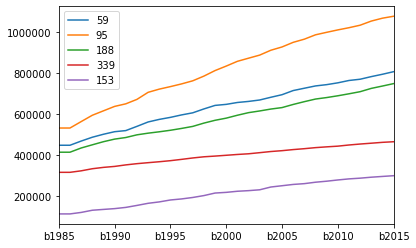

In [76]:
city_built = city_built.sort_values(by=['Pop'], ascending=False)
city_built.iloc[:5,:-2].transpose().plot.line()

In [86]:
city_built.iloc[:5,]

,b1985,b1986,b1987,b1988,b1989,b1990,b1991,b1992,b1993,b1994,...,b2008,b2009,b2010,b2011,b2012,b2013,b2014,b2015,ID,Pop
59,447815,447815,468220,486989,501565,514045,519455,540125,561603,574214,...,737747,744081,752939,764427,770552,783357,794838,807471,2821,9896907.00
95,532047,532047,563389,594418,616104,637730,650263,672024,706525,722170,...,987664,999885,1011655,1022419,1034647,1054855,1068957,1078433,2870,6588687.50
188,413800,413800,434370,449939,465193,477825,485622,498750,506867,513584,...,673629,680960,689622,699350,709655,725804,737259,749154,2978,5240911.50
339,315458,315458,322753,333013,339633,344338,351800,357795,362600,367217,...,436177,439990,443395,449092,453752,457832,462053,464998,3135,3041159.25
153,112149,112149,119398,130101,134155,138036,143996,153660,164029,170855,...,267121,272083,278113,283392,286906,291644,295367,298964,2932,2288379.50


In [79]:
nuts_built['ID'] = inD['nuts2_regions']
nuts_built['Name'] = inD['nuts2_labels']

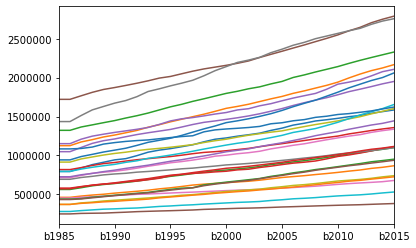

In [88]:
nuts_built.iloc[:,:-2].transpose().plot.line(legend=False)

In [89]:
nuts_built.to_csv("/home/wb411133/temp/TUR/NUTS2_WSF.csv")

In [90]:
city_built.to_csv("/home/wb411133/temp/TUR/TUR_Cities_WSF.csv")